# The Cost of Basic Goods
Anna Pauxberger
10 November 2018

### Modeling Product Prices
This is a model of **grocery prices** in different neighborhoods of Berlin. The goal is to show how the brand of a product, the brand of the grocery store and the geographical location of the store affect product prices, by looking at their multipliers. I use **Bayesian statistics** to generate samples from posteriors using **PyStan**. 


### The Stan Model
The  Stan model finds base prices and multipliers for stores, locations and brands. As an input, it takes lists of prices, product names, store names, location names, and brand names. It first defines priors for each parameter. After defining the priors, the model estimates the posterior parameter by multiplying the priors with the normal likelihood for the data, which is a function of base price multiplied by all multipliers. See details below.


### Results
Base prices range from 0.83 euros for a kilogram of apples to 9.82 euros for 0.5kg of chicken breasts. The multipliers for location are among the strongest, such as the multiplier for Alt-Treptow with 4.61 or Neukölln with 3.2, meaning a product bought in Alt-Treptow tends to be much more expensive than in Neukoölln. The brand multipliers are rather small with values around 1. Store multipliers with around 0.53-0.71 are also of smaller importance, indicating that stores do not seem to affect prices much.

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pystan
from scipy.stats import cauchy, gamma, norm, expon, uniform
import pandas as pd

# Data Preprocessing

The data was manually cleaned to account for human error in data inputs. For example, if bananas were called 'edekea bananas' vs 'bananas edeka', one was chosen to representa ll. If brands such as 'apples' were assigned, they were rebranded to 'nobrand'. Brands such as 'gut und guenstig', which has an astounding amount of different spellings, were replaced by one version as well. Entries that were not supposed to be in the category (e.g. pork instead of chicken) were deleted.

In [3]:
data = pd.read_csv("product_data.csv", skiprows=1)
data = data.drop(["Timestamp", "Your name", "Grocery store street address","Email Address"], axis=1)

In [4]:
temp = []
c = -1
column_names = list(data)

for row in data.iterrows():
    i, row_data = row
    row_data = row_data.tolist()
    store = row_data[0]
    neighborhood = row_data[1]
    
    for c in range(2, 62, 2):
        product = column_names[c]
        brand = row_data[c]
        price = row_data[c+1]
        observation = [product, store, neighborhood, brand, price]
    
        temp.append(observation)

In [5]:
temp = pd.DataFrame(temp)
temp.columns=['product','store','neighborhood','brand','price']

temp['product'] = temp['product'].str.lower()
temp['product'] = temp['product'].str.replace("[^A-Za-z]+", "")

temp['store'] = temp['store'].str.lower()
temp['neighborhood'] = temp['neighborhood'].str.lower()

temp['brand'] = temp['brand'].str.lower()
temp['brand'] = temp['brand'].str.replace("[^A-Za-z]+", "")

In [6]:
# Lower number of brands
vc = temp['brand'].value_counts()
big_brands = vc[vc>15]

def label_brand(row):
    if row['brand'] in big_brands:
        return row['brand']
    else:
        return "no brand"

temp["brand"]= temp.apply(lambda row: label_brand(row), axis=1)
temp.head()

,product,store,neighborhood,brand,price
0,apple,aldi,mitte,no brand,0.79
1,apple,aldi,mitte,gutbio,3.65
2,apple,aldi,mitte,no brand,1.99
3,banana,aldi,mitte,no brand,1.09
4,banana,aldi,mitte,gutbio,1.69


In [7]:
encoded = temp
# +1 to allow for indexing in stan
encoded['product'] = encoded['product'].astype('category').cat.codes +1
encoded['store'] = encoded['store'].astype('category').cat.codes +1
encoded['neighborhood'] = encoded['neighborhood'].astype('category').cat.codes +1
encoded['brand'] = encoded['brand'].astype('category').cat.codes +1

encoded.head()

,product,store,neighborhood,brand,price
0,1,1,6,14,0.79
1,1,1,6,7,3.65
2,1,1,6,14,1.99
3,2,1,6,14,1.09
4,2,1,6,7,1.69


# Choice of Priors and Hyperparameters

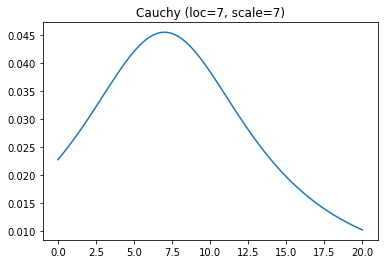

In [76]:
# Cauchy Hyperparameters
# Prior for base prices
# Assuming that the prices lie somewhere between 0-20 Euro
# Assuming that most of them will be around 7 Euro, but with large deviations

x = np.linspace(0,20, 100)
plt.plot(x, cauchy.pdf(x,loc=7,scale=7))
plt.title("Cauchy (loc=7, scale=7)")
plt.show()

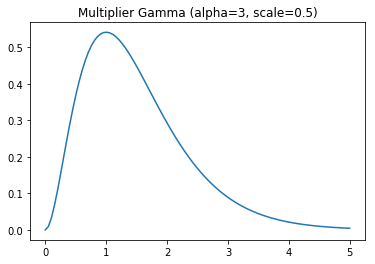

In [85]:
# Gamma Hyperparameters (multipliers)
# Prior for multipliers
# Assuming that the multiplier lies somewhere between 0-5
# Centered at 1, where there is no multiplier
x = np.linspace(0,5, 100)
plt.plot(x, gamma.pdf(x,a=3, scale=0.5))
plt.title("Multiplier Gamma (alpha=3, scale=0.5)")
plt.show()

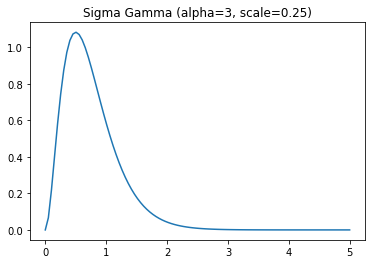

In [86]:
# Gamma Hyperparameters (sigma)
# Prior for sigma
# Assuming that the multiplier lies somewhere between 0-2
# Most likely around 1
x = np.linspace(0,5, 100)
plt.plot(x, gamma.pdf(x,a=3, scale=0.25))
plt.title("Sigma Gamma (alpha=3, scale=0.25)")
plt.show()

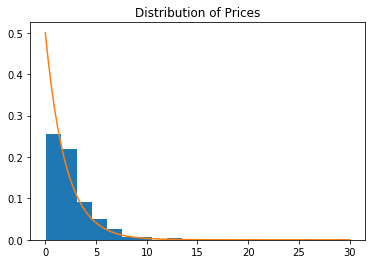

In [105]:
x = np.linspace(0,30, 100)
plt.hist(encoded['price'],bins=20,density=True)

plt.plot(x, expon.pdf(x,loc=0, scale=2))
plt.title('Distribution of Prices')
plt.show()

# Stan Model
The following Stan model finds base prices and multipliers for stores, locations and brands. As an input, it takes lists of prices, product names, store names, location names, and brand names. Each row represents one obervation including each of those informations. 

The data block defines the information we already know. For example, how many different stores there are, thus how many store multipliers we need, what observations have what stores, and what hyperparameters we are choosing for our base price prior. 

The parameters block defines the parameters we want to estimate with our model. That includes the base price for each product, the multipliers for all variables (store, location, brand) and a sigma parameter for the normal distribution. 

In the model we connect the parameters to the data. First we define priors for each parameter. The prior for the base price is a cauchy distribution with location 7 and scale 7, as this is a heavy tail distribution and provides a rather uninformed prior for our base price, which is good as we have little knowledge about the base price. The gamma priors for the multipliers work with the assumption that the multipliers will be somewhere between 0 and 5, centered at around 1. The gamma prior for sigma peaks at 1, which is the most likely standard deviation. 

After defining the priors, the model estimates the posterior parameter by multiplying the priors with the normal likelihood for the data, which is a function of base price multiplied by all multipliers. The assumption that the prices are normally distributed is quite a large one, and does not hold true, as we can see in the image above. 

In [100]:
stan_code = '''

data {
    // define the amount of observations, products, ... in the data
    int<lower=1> N;             // number of observations
    int<lower=1> P;             // number of products
    int<lower=1> S;             // number of stores
    int<lower=1> L;             // number of locations (neighborhoods)
    int<lower=1> B;             // number of brands
    
    // each observation has one price, product, store, location, and brand
    // the dictionary to decode the category encoding  can be found in the appendix
    real<lower=0> price[N];    // all prices
    int<lower=1> product[N];   // all products
    int<lower=1> store[N];     // all stores
    int<lower=1> location[N];  // all locations
    int<lower=1> brand[N];     // all brands
    
    // hyperparameters
    real loc;                  // prior hyperparameters for cauchy
    real<lower=0> scale;       // prior hyperparameters for cauchy
    real<lower=0> alpha;       // prior hyperparameter for gamma
    real<lower=0> beta;        // prior hyperparameter for gamma
    real<lower=0> s_alpha;     // prior hyperparameter for gamma
    real<lower=0> s_beta;      // prior hyperparameter for gamma
}

parameters {
    // parameters the model will compute posteriors for
    real<lower=0> base_price[P];     // vector for base prices            
    real<lower=0> store_m[S];        // vector for store multipliers
    real<lower=0> loc_m[L];          // vector for location multipliers
    real<lower=0> brand_m[B];        // vector for brand multipliers 
    real<lower=0> sigma;             // standard deviation for normal
}

model{
    // base price and multiplier priors
    base_price ~ cauchy(loc, scale);
    store_m ~ gamma(alpha,beta);
    loc_m ~ gamma(alpha,beta);
    brand_m ~ gamma(alpha,beta);
    sigma ~ gamma(s_alpha,s_beta);
    
    // price likelihoods (14=nobrand, thus no multiplier)
    for (i in 1:N){
        if (brand[i] == 14){
            price[i] ~ normal(base_price[product[i]]* store_m[store[i]] * loc_m[location[i]], sigma);
        } else{
            price[i] ~ normal(base_price[product[i]]* store_m[store[i]] * loc_m[location[i]] * brand_m[brand[i]], sigma);
        }
    }
}
'''
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c96420847fa724573238d74bc3b49145 NOW.


In [121]:
data = {
    'N': len(encoded),
    'P': encoded['product'].nunique(),
    'S': encoded['store'].nunique(),
    'L': encoded['neighborhood'].nunique(),
    'B': encoded['brand'].nunique(),
    
    'price': np.asarray(encoded['price']),
    'product': np.asarray(encoded['product']),
    'store': np.asarray(encoded['store']),
    'location': np.asarray(encoded['neighborhood']),
    'brand': np.asarray(encoded['brand']),
    
    'loc': 7,
    'scale': 7,
    'alpha': 3,
    'beta': 0.5,
    's_alpha': 4,
    's_beta': 0.25}

results = stan_model.sampling(data=data)
samples = results.extract()


Note: I was not able to run the code with an adjusted max_treedepth. However, since less than 1% of the data is affected, I concluded that this is a limitation of the model but should not have a significant impact on the results. 

In [124]:
print(results)

Inference for Stan model: anon_model_c96420847fa724573238d74bc3b49145.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]    1.74    0.07   1.27   0.24   0.77   1.44   2.37   4.95    331   1.01
base_price[2]    1.17    0.05   0.86   0.16   0.52   0.97   1.58   3.33    341   1.01
base_price[3]    3.49    0.14   2.54   0.49   1.57    2.9   4.71   9.93    333   1.01
base_price[4]    9.82    0.39   7.13   1.37   4.41   8.14   13.3  27.79    332   1.01
base_price[5]    2.34    0.09    1.7   0.32   1.04   1.95   3.18   6.53    333   1.01
base_price[6]    0.92    0.04   0.68   0.12   0.41   0.75   1.25   2.62    338   1.01
base_price[7]    0.83    0.03   0.61   0.11   0.36   0.68   1.13   2.35    341   1.01
base_price[8]    1.04    0.04   0.76   0.15   0.46   0.85    1.4   2.92    334   1.01
base_price[9]    2.36    0.09   1.72 

# Analysis of Results
The multipliers for location are among the strongest with around 3-4, such as the multiplier for loc_m[1], Alt-Treptow, with 4.61 as opposed to locm[7], Neukölln, which is 3.2. A product bought in Alt-Treptow tends to be much more expensive than in Neukoölln. The brand multipliers are rather small with values around 1. An exception is brand_m[14], which is no brand, with a 6, indicating that it increases the estimated price by a lot. Since in my data cleaning process I defined brands with few occurrences to be 'no brand' as well, there could be outliers that pull the value so high. Store multipliers with around 0.53-0.71 are also of little importance, as the values are rather small and similar to each other.

### How much is the basic average price for each product?

### Base Price

In [192]:
products = list(dict(enumerate(temp['product'].astype('category').cat.categories)).values())
base = []
for i in range(encoded['product'].nunique()):
    base.append(round(np.mean(samples['base_price'][:,i]),2))
    
pd.DataFrame({'product': products, 'base_price': base})

,product,base_price
0,apple,1.74
1,banana,1.17
2,butter,3.49
3,chicken,9.82
4,eggs,2.34
5,flour,0.92
6,milk,0.83
7,potato,1.04
8,rice,2.36
9,tomato,2.79


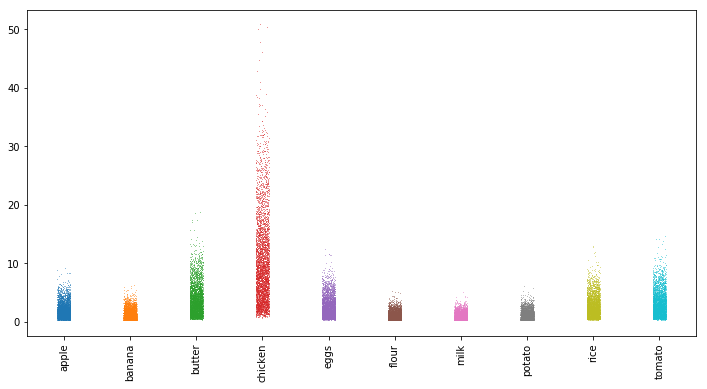

In [180]:
# Base Prices
plt.figure(figsize=(12, 6))
for i in range(encoded['product'].nunique()):
    plt.plot(uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['base_price'][:,i], ',', alpha=0.5)
plt.xticks(list(range(0, encoded['product'].nunique())), 
           dict(enumerate(temp['product'].astype('category').cat.categories)).values(), rotation=90)  
plt.show()

### Multipliers
### How much does each of the following factors modify the basic price of the product (up or down)?

### Stores

In [205]:
stores = list(dict(enumerate(temp['store'].astype('category').cat.categories)).values())

store_means = []
for i in range(encoded['store'].nunique()):
    store_means.append(round(np.mean(samples['store_m'][:,i]),2))
    
pd.DataFrame({'stores': stores, 'store multiplier': store_means})

,stores,store multiplier
0,aldi,0.51
1,edeka,0.68
2,lidl,0.43
3,rewe,0.54


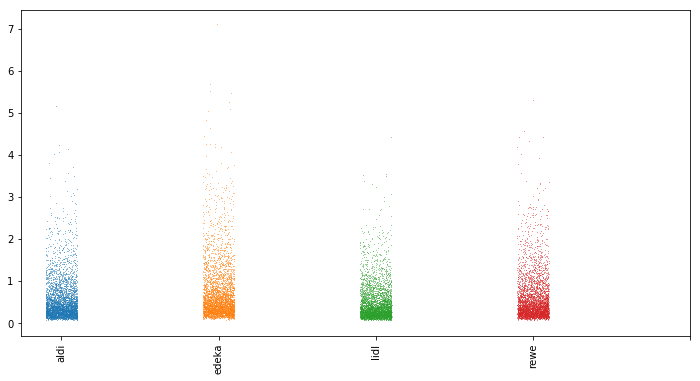

In [161]:
# Store Multiplier
plt.figure(figsize=(12, 6))
for i in range(encoded['store'].nunique()):
    plt.plot(uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['store_m'][:,i], ',', alpha=0.5)
plt.xticks(list(range(encoded['store'].nunique()+1)), 
           dict(enumerate(temp['store'].astype('category').cat.categories)).values(), rotation=90)  
plt.show()

### Location

In [204]:
location = list(dict(enumerate(temp['neighborhood'].astype('category').cat.categories)).values())

loc_means = []
for i in range(encoded['neighborhood'].nunique()):
    loc_means.append(round(np.mean(samples['loc_m'][:,i]),2))
    
pd.DataFrame({'location': location, 'location multiplier': loc_means})

,location,location multiplier
0,alt-treptow,4.09
1,friedrichshain,3.97
2,kreuzberg,4.09
3,lichtenberg,4.10
4,london,3.05
5,mitte,4.18
6,neukölln,3.22
7,prenzlauer berg,3.58
8,schöneberg,3.75
9,tempelhof,4.64


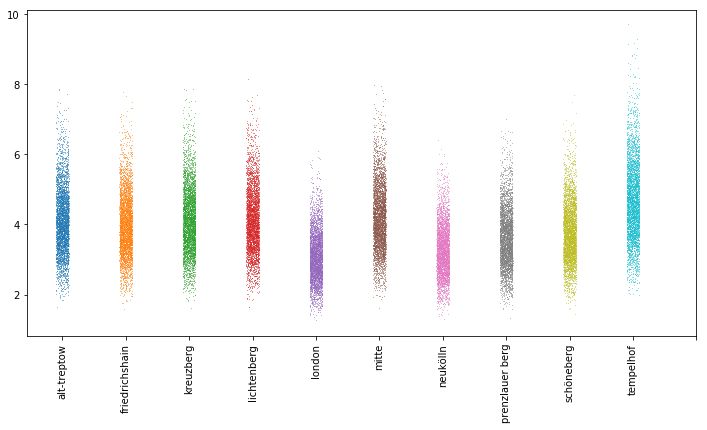

In [163]:
# Location Multiplier
plt.figure(figsize=(12, 6))
for i in range(encoded['neighborhood'].nunique()):
    plt.plot(uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['loc_m'][:,i], ',', alpha=0.5)
plt.xticks(list(range(encoded['neighborhood'].nunique()+1)), 
           dict(enumerate(temp['neighborhood'].astype('category').cat.categories)).values(), rotation=90)  
plt.show()

### Brands

In [202]:
brands = list(dict(enumerate(temp['brand'].astype('category').cat.categories)).values())

brand_means = []
for i in range(encoded['brand'].nunique()):
    brand_means.append(round(np.mean(samples['brand_m'][:,i]),2))
    
pd.DataFrame({'brands': brands, 'brand multiplier': brand_means})

,brands,brand multiplier
0,baerenmarke,1.46
1,bio,2.05
2,bioorganic,1.17
3,bodenhaltung,0.84
4,edeka,0.85
5,edekabio,1.29
6,gutbio,1.23
7,gutguenstig,0.52
8,ja,0.61
9,kerrygold,1.15


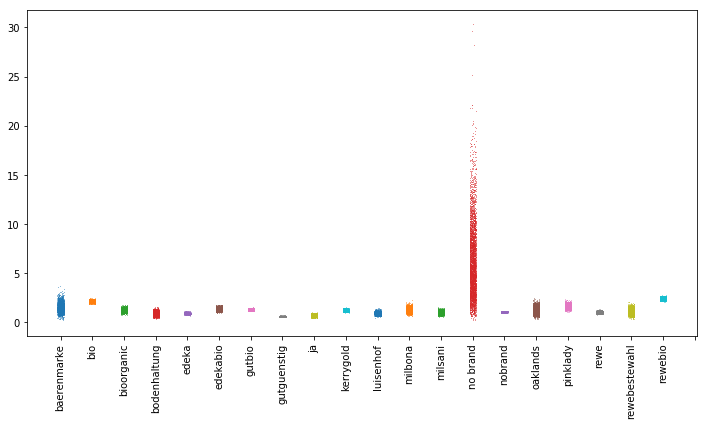

In [162]:
# Brands
plt.figure(figsize=(12, 6))
for i in range(encoded['brand'].nunique()):
    plt.plot(uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['brand_m'][:,i], ',', alpha=0.5)
plt.xticks(list(range(encoded['brand'].nunique()+1)), 
           dict(enumerate(temp['brand'].astype('category').cat.categories)).values(), rotation=90)  
plt.show()

# Real Estate Prices

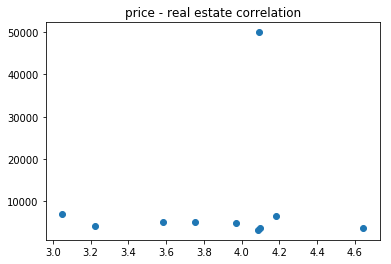

R:0.12, p-value:0.12
There is no correlation between prices and real estate.


In [177]:
# https://guthmann-estate.com/marketreport/real-estate-report/?fbclid=IwAR2l8tGH_Mta-Ybc6NVaAYs683CBD_vLfDRXj1wcZ5wdiBUEwrKZTTNJf-0
# https://www.numbeo.com/property-investment/in/London
# prices per square meter

real_estate = [3200, 4900, 50000, 3700, 7000, 6400, 4200, 5100, 5100, 3600]
neighborhood = dict(enumerate(temp['neighborhood'].astype('category').cat.categories)).values()
prices = []
for i in range(encoded['neighborhood'].nunique()):
    prices.append(np.mean(samples['loc_m'][:,i]))

plt.scatter(prices, real_estate)
plt.title('price - real estate correlation')
plt.show()


from scipy.stats.stats import pearsonr
corr, p_value = pearsonr(prices, real_estate)
print("R:{0:.2f}, p-value:{0:.2f}".format(corr, p_value))
print("There is no correlation between prices and real estate.")

# Appendix


Items and quantity:
- Apples — 1kg
- Bananas — 1kg
- Tomatoes — 1kg
- Potatoes — 1kg
- Flour — white, 1 kg
- Rice — white, 1 kg
- Milk — full cream, 1 liter
- Butter — 500g
- Eggs — regular size, 12
- Chicken breasts — boneless and skinless, 1 kg

In [58]:
dict(enumerate(temp['product'].astype('category').cat.categories))

{0: 'apple',
 1: 'banana',
 2: 'butter',
 3: 'chicken',
 4: 'eggs',
 5: 'flour',
 6: 'milk',
 7: 'potato',
 8: 'rice',
 9: 'tomato'}

In [61]:
dict(enumerate(temp['store'].astype('category').cat.categories))

{0: 'aldi', 1: 'edeka', 2: 'lidl', 3: 'rewe'}

In [60]:
dict(enumerate(temp['neighborhood'].astype('category').cat.categories))

{0: 'alt-treptow',
 1: 'friedrichshain',
 2: 'kreuzberg',
 3: 'lichtenberg',
 4: 'london',
 5: 'mitte',
 6: 'neukölln',
 7: 'prenzlauer berg',
 8: 'schöneberg',
 9: 'tempelhof'}

In [57]:
dict(enumerate(temp['brand'].astype('category').cat.categories))

{0: 'baerenmarke',
 1: 'bio',
 2: 'bioorganic',
 3: 'bodenhaltung',
 4: 'edeka',
 5: 'edekabio',
 6: 'gutbio',
 7: 'gutguenstig',
 8: 'ja',
 9: 'kerrygold',
 10: 'luisenhof',
 11: 'milbona',
 12: 'milsani',
 13: 'no brand',
 14: 'nobrand',
 15: 'oaklands',
 16: 'pinklady',
 17: 'rewe',
 18: 'rewebestewahl',
 19: 'rewebio'}